In [234]:
import json
import time
import glob
import math
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from itertools import permutations
from ipywidgets import IntProgress
from scipy.interpolate import lagrange
from IPython.display import display
from IPython.display import clear_output


In [235]:
timeout = 120
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.cumsum(np.random.exponential(scale=1/LAMBDA, size=(a,)))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(a,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self


In [236]:
def find_local_best(s, sortedTasks, unsortedTasks):
    
    def find_L_max(task):
        pi = sortedTasks + [task]
        return s[pi].L_max()

    return min(unsortedTasks, key=find_L_max)

In [237]:
s = TaskSet(4)

In [238]:
find_local_best(s, [2, 1], [0, 3])

3

In [239]:
s[[2,1,3]].L_max()

325.25157026982436

In [240]:
# m is the num of machines
def greedy_Lmax(s, m):
    bestLmax = float('inf')
    piArray = [[] for i in range(m)]
    unsortedTasks = [i for i in range(len(s))]
    
    for i in range(len(s)):
        localPiArray = copy.deepcopy(piArray)
        bestLmax = float('inf')
        for j in range(m):
            sortedTasks = piArray[j]
            bestTask = find_local_best(s, sortedTasks, unsortedTasks)
            localPiArray[j] += [bestTask]
            currLmax = s[localPiArray[j]].L_max()
            if currLmax < bestLmax:
                bestLmax = currLmax
                bestj = j
                globalBestTask = bestTask
        piArray[bestj] += [globalBestTask]
        unsortedTasks.remove(globalBestTask)
    return bestLmax, piArray

In [241]:
def greedy_r(s, m):
    bestLmax = float('inf')
    piArray = [[] for i in range(m)]
    unsortedTasks = [i for i in range(len(s))]
    for i in unsortedTasks:
        localPiArray = copy.deepcopy(piArray)
        bestLmax = float('inf')
        for j in range(m):
            localPiArray[j].append(i)
            Lmax = s[localPiArray[j]].L_max()
            if Lmax < bestLmax:
                bestLmax = Lmax
                bestj = j
        piArray[bestj].append(i)
    return max([s[pi].L_max() for pi in piArray if len(pi) > 0]), piArray

In [242]:
def bruteforce(s):
    bestPi1 = []
    bestPi2 = []
    pi = [i for i in range(len(s))]
    bestLmax = float('inf')
    for perm in permutations(pi):
        for i in range(len(s)+1):
            pi1 = perm[:i]
            pi2 = perm[i:]
            #print(pi1, pi2)
            if len(pi1) == 0:
                tLmax = s[list(pi2)].L_max()
            elif len(pi2) == 0:
                tLmax = s[list(pi1)].L_max()
            else:
                tLmax = max(s[list(pi1)].L_max(), s[list(pi2)].L_max())
            if tLmax < bestLmax:
                bestLmax = tLmax
                bestPi1 = list(pi1).copy()
                bestPi2 = list(pi2).copy()
    return bestLmax, bestPi1, bestPi2

In [243]:
s = TaskSet(5)

In [244]:
greedy_r(s, 5)

(-916.4791069660032, [[0, 2], [1], [3], [4], []])

In [245]:
bruteforce(s)

(-916.4791069660032, [0, 2, 4], [1, 3])

In [246]:
s[[4]].L_max()

-945.1086112325315

In [247]:
def brute_test(func, N_TASKS=100):
    results = []
    pBar = IntProgress(min=0, max=N_TASKS)
    display(pBar)
    for i in range(N_TASKS):
        s = TaskSet(5)
        gL = func(s, 2)[0]
        bL = bruteforce(s)[0]
        if gL < bL:
            #print("Smth wrong with bruteforce")
            raise RuntimeError("Smth wrong with bruteforce")
        results.append((gL - bL)/np.abs(bL)*100)
        pBar.value += 1
    return pd.DataFrame([[max(results), min(results), np.mean(results)]], columns=["Максимум отклонения, %", "Минимум отклонения, %", "Среднее отклонение, %"])


In [175]:
brute_test(greedy_Lmax)

IntProgress(value=0)

,"Максимум отклонения, %","Минимум отклонения, %","Среднее отклонение, %"
0,1839.977821,0.0,100.120743


In [176]:
brute_test(greedy_r)

IntProgress(value=0)

,"Максимум отклонения, %","Минимум отклонения, %","Среднее отклонение, %"
0,6.467389,0.0,0.197566


IntProgress(value=0, max=21)

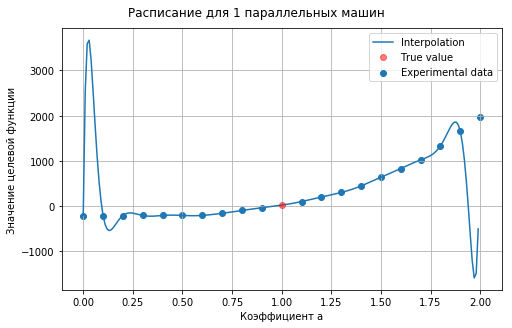

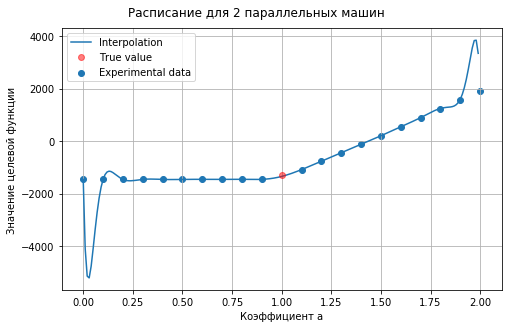

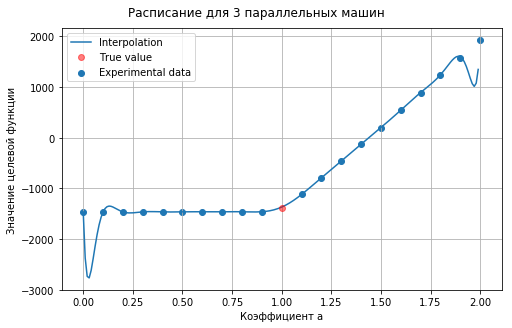

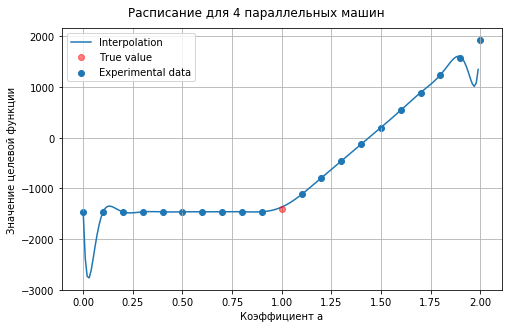

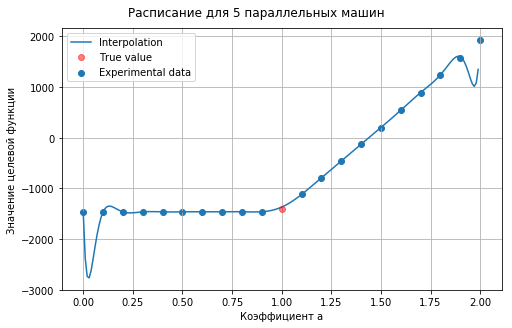

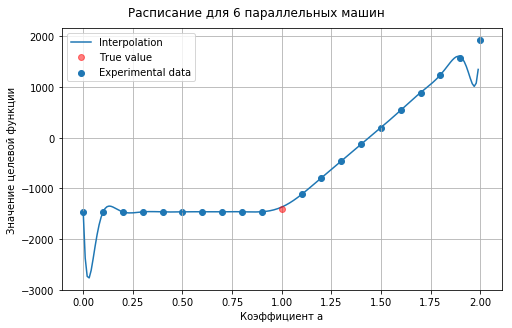

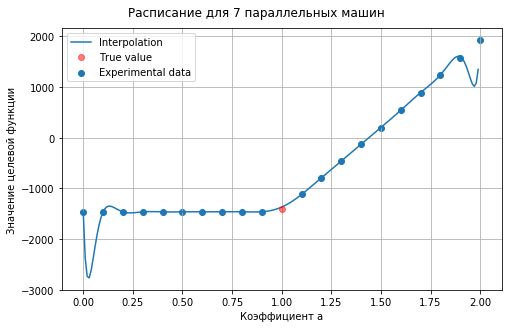

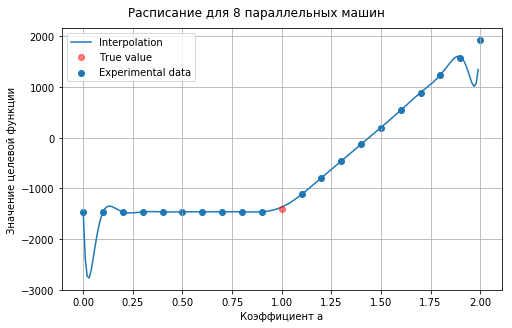

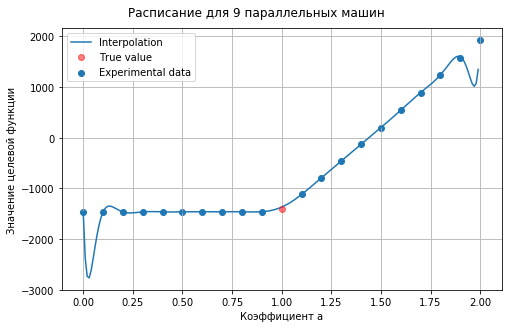

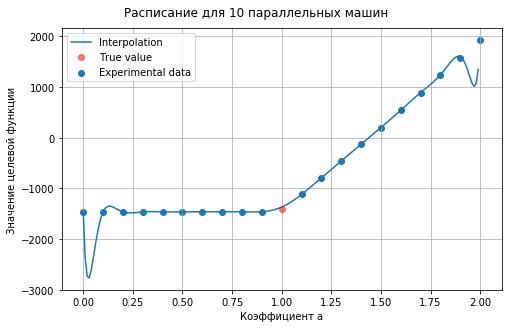

In [195]:
#alphaRange = remove(np.arange(0, 2, 0.1), 1.)
alphaRange = np.arange(0, 2.1, 0.1)
N_TASKS = 5

s = TaskSet(5)
prgBar = IntProgress(min = 0, max = len(alphaRange))
display(prgBar)
for n in range(N_TASKS):
    prgBar.value = 0
    m = n + 1
    scaledSchedules = []
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    
    #print("\rCurrently working with", n)
    approxResults = []
    if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
    for i, a in enumerate(alphaRange):
        Lmax = greedy_r(scaledSchedules[i], m)[0]
        prgBar.value = prgBar.value + 1
        approxResults.append((a, Lmax))
    approxResults = np.array(approxResults)
    trueIndex = np.where(np.isclose(approxResults[:,0], 1.))[0]
    if trueIndex: 
        trueIndex = trueIndex[0]
        trueValue = approxResults[trueIndex]
        approxResults = np.delete(approxResults, trueIndex, axis=0)
    x = approxResults[:,0]
    y = approxResults[:,1]
    #print(x, y)
    poly = lagrange(x, y)
    xp = np.arange(x[0], x[-1], 0.01)
    yp = poly(xp)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
    fig.suptitle("Расписание для %s параллельных машин" % m)
    axes.scatter(x, y, label="Experimental data")
    axes.plot(xp, yp, label="Interpolation")
    axes.grid()
    axes.set_xlabel("Коэффициент а")
    axes.set_ylabel("Значение целевой функции")
    axes.plot(1., trueValue[1], 'ro', label="True value", alpha=0.5)
    axes.legend()

IntProgress(value=0, max=10)

  r  |  p  |  d  
[[ 184.64974715  140.75181664 1617.85590584]
 [ 215.44329152  123.92809855 1648.64945022]
 [ 217.20025661   60.03879098 1650.4064153 ]
 [ 254.53363999   87.968985   1687.73979868]
 [ 753.34023081   66.59874824 2186.54638951]
 [ 888.6742681   135.5910207  2321.8804268 ]
 [1145.21624235   57.98377201 2578.42240105]
 [1162.56471714  163.33161183 2595.77087583]
 [1467.90065553  141.31178379 2901.10681423]
 [1585.14071699   92.51176477 3018.34687568]
 [1611.43196876  151.53894567 3044.63812746]
 [1691.54565154   80.86023425 3124.75181024]
 [1706.91279509  105.14927687 3140.11895378]
 [1924.72858131  125.50980837 3357.93474   ]
 [1959.33236267   48.4508787  3392.53852137]
 [2094.68420309   81.08784683 3527.89036178]
 [2280.3049886   152.36302254 3713.5111473 ]
 [2386.25378987  110.63881601 3819.45994856]
 [2484.6305715   107.98218749 3917.8367302 ]
 [2708.23426187  107.25038349 4141.44042057]
 [2742.04493384   75.17518055 4175.25109253]
 [2806.09803614  126.89488766 4239.30

  r  |  p  |  d  
[[ 184.64974715  140.75181664 1617.85590584]
 [ 215.44329152  123.92809855 1648.64945022]
 [ 217.20025661   60.03879098 1650.4064153 ]
 [ 254.53363999   87.968985   1687.73979868]
 [ 753.34023081   66.59874824 2186.54638951]
 [ 888.6742681   135.5910207  2321.8804268 ]
 [1145.21624235   57.98377201 2578.42240105]
 [1162.56471714  163.33161183 2595.77087583]
 [1467.90065553  141.31178379 2901.10681423]
 [1585.14071699   92.51176477 3018.34687568]
 [1611.43196876  151.53894567 3044.63812746]
 [1691.54565154   80.86023425 3124.75181024]
 [1706.91279509  105.14927687 3140.11895378]
 [1924.72858131  125.50980837 3357.93474   ]
 [1959.33236267   48.4508787  3392.53852137]
 [2094.68420309   81.08784683 3527.89036178]
 [2280.3049886   152.36302254 3713.5111473 ]
 [2386.25378987  110.63881601 3819.45994856]
 [2484.6305715   107.98218749 3917.8367302 ]
 [2708.23426187  107.25038349 4141.44042057]
 [2742.04493384   75.17518055 4175.25109253]
 [2806.09803614  126.89488766 4239.30

  r  |  p  |  d  
[[ 184.64974715  140.75181664 1617.85590584]
 [ 215.44329152  123.92809855 1648.64945022]
 [ 217.20025661   60.03879098 1650.4064153 ]
 [ 254.53363999   87.968985   1687.73979868]
 [ 753.34023081   66.59874824 2186.54638951]
 [ 888.6742681   135.5910207  2321.8804268 ]
 [1145.21624235   57.98377201 2578.42240105]
 [1162.56471714  163.33161183 2595.77087583]
 [1467.90065553  141.31178379 2901.10681423]
 [1585.14071699   92.51176477 3018.34687568]
 [1611.43196876  151.53894567 3044.63812746]
 [1691.54565154   80.86023425 3124.75181024]
 [1706.91279509  105.14927687 3140.11895378]
 [1924.72858131  125.50980837 3357.93474   ]
 [1959.33236267   48.4508787  3392.53852137]
 [2094.68420309   81.08784683 3527.89036178]
 [2280.3049886   152.36302254 3713.5111473 ]
 [2386.25378987  110.63881601 3819.45994856]
 [2484.6305715   107.98218749 3917.8367302 ]
 [2708.23426187  107.25038349 4141.44042057]
 [2742.04493384   75.17518055 4175.25109253]
 [2806.09803614  126.89488766 4239.30

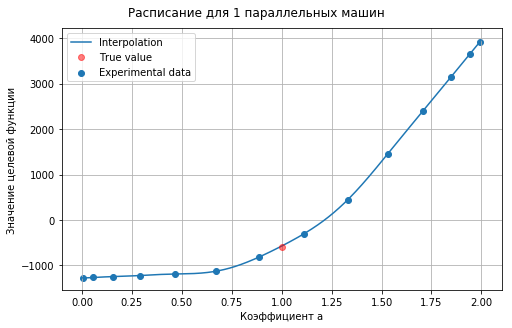

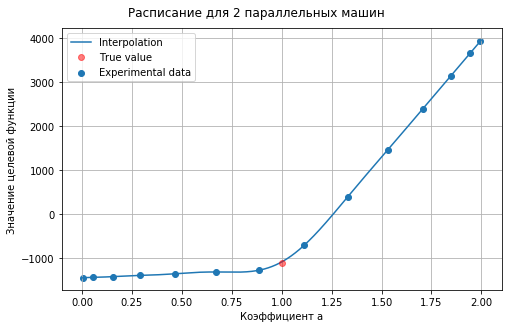

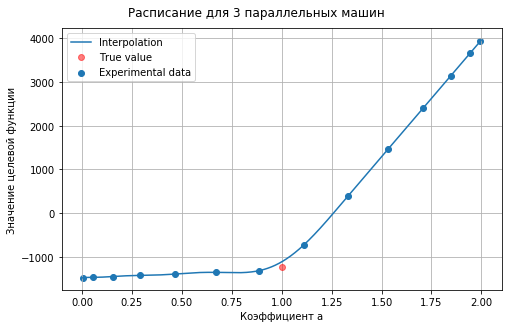

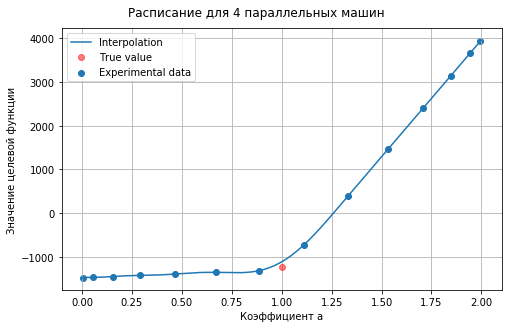

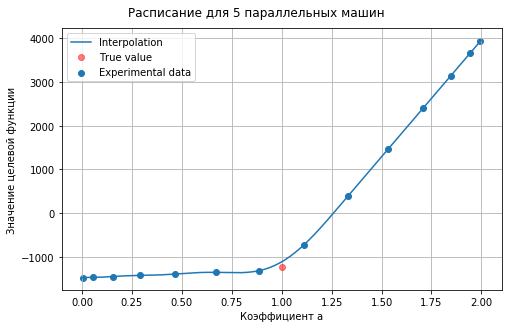

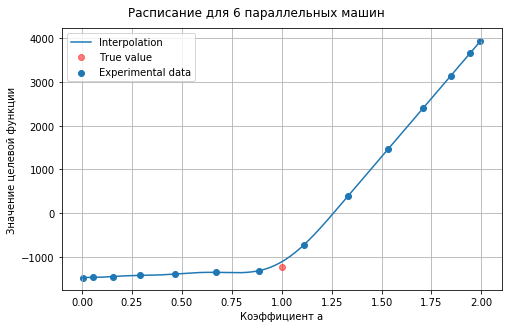

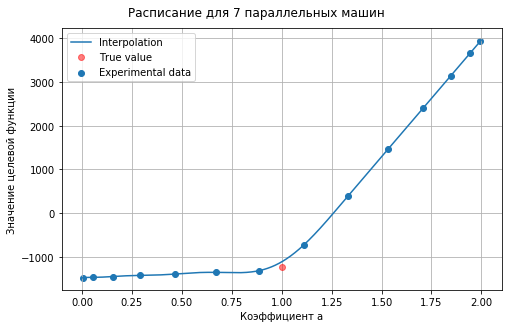

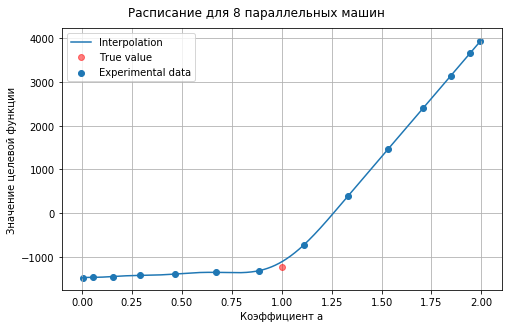

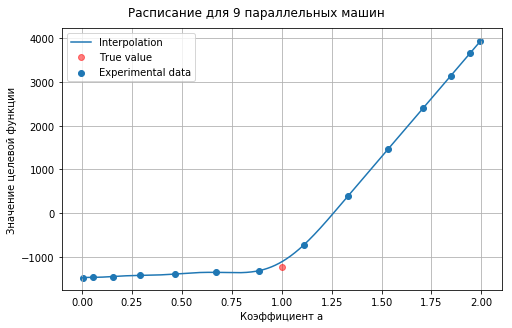

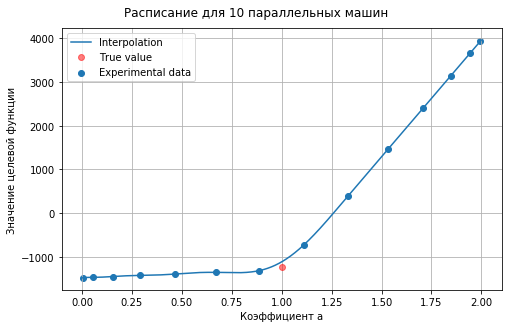

In [249]:
global realResult
global approxResults
global m
global s
s = TaskSet(50)

def test_schedule(alpha_arr):
    global approxResults
    global realResult
    global m
    global s
    approxResults = []
    print(s)
    for a in alpha_arr:
        #print("\ra =", a, end='')
        scaled_s = s.copy().scale_r(a)
        #flattenedScaled_s = list(map(lambda x: x.array.flatten(), scaled_s))
        Lmax = greedy_r(scaled_s, m)[0]
        approxResults.append((a, Lmax))
    realResult = (1., greedy_r(s, m)[0])
    approxResults = np.array(approxResults)
    return approxResults[:,1]

N_TASKS = 10
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
for i in range(N_TASKS):
    m = i + 1
    C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
    approxResults = np.array(approxResults)
    
    x = approxResults[:,0]
    y = approxResults[:,1]
    xp = np.arange(0, 2, 0.001)
    yp = C(xp)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
    fig.suptitle("Расписание для %s параллельных машин" % m)
    axes.scatter(x, y, label="Experimental data")
    axes.plot(xp, yp, label="Interpolation")
    axes.grid()
    axes.set_xlabel("Коэффициент а")
    axes.set_ylabel("Значение целевой функции")
    axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
    axes.legend()
    pBar.value += 1

In [248]:
N_TASKS = 5
prgBar = IntProgress(min=0, max=N_TASKS)
display(prgBar)
#global realResult
#global approxResults
#global s
#global m
globalResults = []
for n in range(N_TASKS):
    s = TaskSet(5)
    prgBar.value += 1
    scaledSchedules = []
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    results = []
    for m in range(1, 4, 1):
        #print("\rCurrently working with", n)
        approxResults = []
        if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
        for i, a in enumerate(alphaRange):
            Lmax = greedy_r(scaledSchedules[i], m)[0]
            print(scaledSchedules[i])
            approxResults.append((a, Lmax))
        approxResults = np.array(approxResults)
        trueIndex = np.where(np.isclose(approxResults[:,0], 1.))[0]
        if trueIndex: 
            trueIndex = trueIndex[0]
            trueValue = approxResults[trueIndex]
            approxResults = np.delete(approxResults, trueIndex, axis=0)
        x = approxResults[:,0]
        y = approxResults[:,1]
        #print(x, y)
        poly = lagrange(x, y)
        results.append((poly(1.) - trueValue[1])/trueValue[1]*100)
    globalResults += [results]
with open("greedyMultipleLagrange.json", 'w') as f:
    json.dump(globalResults, f)

IntProgress(value=0, max=5)

  r  |  p  |  d  
[[   0.          126.85061547 1225.0186783 ]
 [   0.           89.38555479 1225.17445299]
 [   0.          115.01145355 1371.78325179]
 [   0.           67.52046669 1473.97158381]
 [   0.           35.40509384 1483.19019975]]
  r  |  p  |  d  
[[  14.10679203  126.85061547 1225.0186783 ]
 [  14.1223695    89.38555479 1225.17445299]
 [  28.78324938  115.01145355 1371.78325179]
 [  39.00208258   67.52046669 1473.97158381]
 [  39.92394417   35.40509384 1483.19019975]]
  r  |  p  |  d  
[[  28.21358406  126.85061547 1225.0186783 ]
 [  28.244739     89.38555479 1225.17445299]
 [  57.56649876  115.01145355 1371.78325179]
 [  78.00416516   67.52046669 1473.97158381]
 [  79.84788835   35.40509384 1483.19019975]]
  r  |  p  |  d  
[[  42.32037609  126.85061547 1225.0186783 ]
 [  42.3671085    89.38555479 1225.17445299]
 [  86.34974814  115.01145355 1371.78325179]
 [ 117.00624774   67.52046669 1473.97158381]
 [ 119.77183252   35.40509384 1483.19019975]]
  r  |  p  |  d  
[[  56

  r  |  p  |  d  
[[   0.          126.85061547 1225.0186783 ]
 [   0.           89.38555479 1225.17445299]
 [   0.          115.01145355 1371.78325179]
 [   0.           67.52046669 1473.97158381]
 [   0.           35.40509384 1483.19019975]]
  r  |  p  |  d  
[[  14.10679203  126.85061547 1225.0186783 ]
 [  14.1223695    89.38555479 1225.17445299]
 [  28.78324938  115.01145355 1371.78325179]
 [  39.00208258   67.52046669 1473.97158381]
 [  39.92394417   35.40509384 1483.19019975]]
  r  |  p  |  d  
[[  28.21358406  126.85061547 1225.0186783 ]
 [  28.244739     89.38555479 1225.17445299]
 [  57.56649876  115.01145355 1371.78325179]
 [  78.00416516   67.52046669 1473.97158381]
 [  79.84788835   35.40509384 1483.19019975]]
  r  |  p  |  d  
[[  42.32037609  126.85061547 1225.0186783 ]
 [  42.3671085    89.38555479 1225.17445299]
 [  86.34974814  115.01145355 1371.78325179]
 [ 117.00624774   67.52046669 1473.97158381]
 [ 119.77183252   35.40509384 1483.19019975]]
  r  |  p  |  d  
[[  56

  r  |  p  |  d  
[[   0.          113.24083537 1355.14376716]
 [   0.           52.30838813 1477.38770733]
 [   0.           19.30743039 1594.00236091]
 [   0.          109.20499921 1664.16394558]
 [   0.           97.02495541 1712.34150413]]
  r  |  p  |  d  
[[   1.869219    113.24083537 1355.14376716]
 [  14.09361301   52.30838813 1477.38770733]
 [  25.75507837   19.30743039 1594.00236091]
 [  32.77123684  109.20499921 1664.16394558]
 [  37.58899269   97.02495541 1712.34150413]]
  r  |  p  |  d  
[[   3.73843799  113.24083537 1355.14376716]
 [  28.18722602   52.30838813 1477.38770733]
 [  51.51015674   19.30743039 1594.00236091]
 [  65.54247368  109.20499921 1664.16394558]
 [  75.17798538   97.02495541 1712.34150413]]
  r  |  p  |  d  
[[   5.60765699  113.24083537 1355.14376716]
 [  42.28083904   52.30838813 1477.38770733]
 [  77.26523511   19.30743039 1594.00236091]
 [  98.31371051  109.20499921 1664.16394558]
 [ 112.76697808   97.02495541 1712.34150413]]
  r  |  p  |  d  
[[   7

  r  |  p  |  d  
[[   0.          139.4282535  1083.55725998]
 [   0.           93.88413559 1274.03240341]
 [   0.          137.98862588 1346.49492697]
 [   0.          125.37083604 1525.21059088]
 [   0.           55.65776353 1691.0454679 ]]
  r  |  p  |  d  
[[   6.40848174  139.4282535  1083.55725998]
 [  25.45599609   93.88413559 1274.03240341]
 [  32.70224844  137.98862588 1346.49492697]
 [  50.57381483  125.37083604 1525.21059088]
 [  67.15730254   55.65776353 1691.0454679 ]]
  r  |  p  |  d  
[[  12.81696349  139.4282535  1083.55725998]
 [  50.91199218   93.88413559 1274.03240341]
 [  65.40449689  137.98862588 1346.49492697]
 [ 101.14762967  125.37083604 1525.21059088]
 [ 134.31460507   55.65776353 1691.0454679 ]]
  r  |  p  |  d  
[[  19.22544523  139.4282535  1083.55725998]
 [  76.36798826   93.88413559 1274.03240341]
 [  98.10674533  137.98862588 1346.49492697]
 [ 151.7214445   125.37083604 1525.21059088]
 [ 201.47190761   55.65776353 1691.0454679 ]]
  r  |  p  |  d  
[[  25

 [1007.35953805   55.65776353 1691.0454679 ]]
  r  |  p  |  d  
[[ 102.53570792  139.4282535  1083.55725998]
 [ 407.2959374    93.88413559 1274.03240341]
 [ 523.2359751   137.98862588 1346.49492697]
 [ 809.18103735  125.37083604 1525.21059088]
 [1074.51684059   55.65776353 1691.0454679 ]]
  r  |  p  |  d  
[[ 108.94418966  139.4282535  1083.55725998]
 [ 432.75193349   93.88413559 1274.03240341]
 [ 555.93822354  137.98862588 1346.49492697]
 [ 859.75485218  125.37083604 1525.21059088]
 [1141.67414312   55.65776353 1691.0454679 ]]
  r  |  p  |  d  
[[ 115.35267141  139.4282535  1083.55725998]
 [ 458.20792958   93.88413559 1274.03240341]
 [ 588.64047199  137.98862588 1346.49492697]
 [ 910.32866701  125.37083604 1525.21059088]
 [1208.83144566   55.65776353 1691.0454679 ]]
  r  |  p  |  d  
[[ 121.76115315  139.4282535  1083.55725998]
 [ 483.66392567   93.88413559 1274.03240341]
 [ 621.34272043  137.98862588 1346.49492697]
 [ 960.90248185  125.37083604 1525.21059088]
 [1275.9887482    55.657

  r  |  p  |  d  
[[   0.          111.6689037  2467.58040349]
 [   0.          144.77776429 2575.22737957]
 [   0.           51.84008163 2580.92251967]
 [   0.           46.26507336 2606.77584534]
 [   0.            7.13349812 2726.92537627]]
  r  |  p  |  d  
[[   3.83746718  111.6689037  2467.58040349]
 [  14.60216479  144.77776429 2575.22737957]
 [  15.1716788    51.84008163 2580.92251967]
 [  17.75701136   46.26507336 2606.77584534]
 [  29.77196446    7.13349812 2726.92537627]]
  r  |  p  |  d  
[[   7.67493436  111.6689037  2467.58040349]
 [  29.20432957  144.77776429 2575.22737957]
 [  30.3433576    51.84008163 2580.92251967]
 [  35.51402273   46.26507336 2606.77584534]
 [  59.54392891    7.13349812 2726.92537627]]
  r  |  p  |  d  
[[  11.51240154  111.6689037  2467.58040349]
 [  43.80649436  144.77776429 2575.22737957]
 [  45.51503639   51.84008163 2580.92251967]
 [  53.27103409   46.26507336 2606.77584534]
 [  89.31589337    7.13349812 2726.92537627]]
  r  |  p  |  d  
[[  15

 [  0.          27.42755657 940.69398701]]
  r  |  p  |  d  
[[  2.10122245  88.52675026 596.69845096]
 [  7.74003268  34.44300113 653.08655325]
 [  8.14802635  50.30897839 657.16648989]
 [ 23.57268054  78.51855618 811.41303178]
 [ 36.50077606  27.42755657 940.69398701]]
  r  |  p  |  d  
[[  4.20244491  88.52675026 596.69845096]
 [ 15.48006537  34.44300113 653.08655325]
 [ 16.29605269  50.30897839 657.16648989]
 [ 47.14536107  78.51855618 811.41303178]
 [ 73.00155212  27.42755657 940.69398701]]
  r  |  p  |  d  
[[  6.30366736  88.52675026 596.69845096]
 [ 23.22009805  34.44300113 653.08655325]
 [ 24.44407904  50.30897839 657.16648989]
 [ 70.71804161  78.51855618 811.41303178]
 [109.50232818  27.42755657 940.69398701]]
  r  |  p  |  d  
[[  8.40488982  88.52675026 596.69845096]
 [ 30.96013073  34.44300113 653.08655325]
 [ 32.59210539  50.30897839 657.16648989]
 [ 94.29072214  78.51855618 811.41303178]
 [146.00310424  27.42755657 940.69398701]]
  r  |  p  |  d  
[[ 10.50611227  88.5267

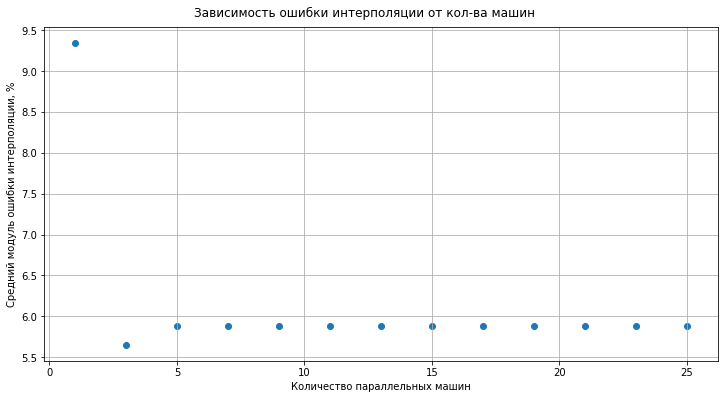

In [230]:
with open("greedyMultipleLagrange.json", 'r') as f:
    globalResults = json.load(f)
globalResults = np.array(globalResults).T
x = []
y = []
for i, res in enumerate(globalResults):
    x.append(2*i + 1)
    y.append(np.mean(np.abs(res)))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от кол-ва машин")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Количество параллельных машин")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()
pBar.value += 1

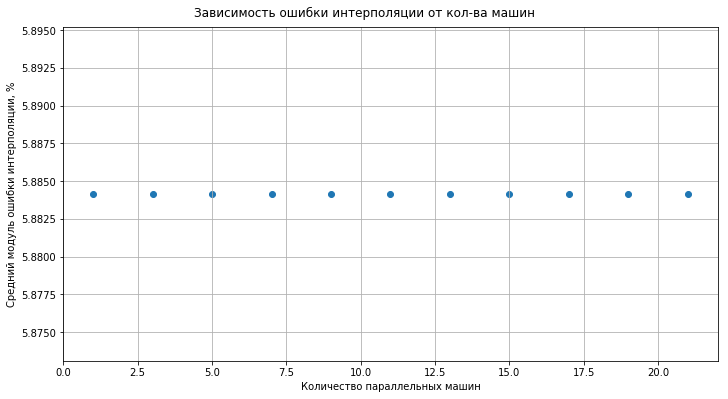

In [232]:
with open("greedyMultipleLagrange.json", 'r') as f:
    globalResults = json.load(f)
globalResults = np.array(globalResults).T
x = []
y = []
for i, res in enumerate(globalResults[2:]):
    x.append(2*i + 1)
    y.append(np.mean(np.abs(res)))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от кол-ва машин")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Количество параллельных машин")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()
pBar.value += 1

In [250]:
N_TASKS = 5
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
global realResult
global approxResults
global s
global m
globalResults = []
for i in range(N_TASKS):
    s = TaskSet(5)
    pBar.value += 1
    results = []
    for n in range(1, 4, 1):
        m = n
        C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
        results.append((C(1.) - realResult[1])/realResult[1]*100)
    globalResults += [results]
with open("greedyMultipleChebyshev.json", 'w') as f:
    json.dump(globalResults, f)

IntProgress(value=0, max=5)

  r  |  p  |  d  
[[  16.08134977  128.17313166  807.13954497]
 [  86.28665582  101.04054283  877.34485102]
 [ 131.38406391  111.63815273  922.44225912]
 [ 215.75633228   58.56324016 1006.81452748]
 [ 304.40094178  140.29070495 1095.45913699]]
  r  |  p  |  d  
[[  16.08134977  128.17313166  807.13954497]
 [  86.28665582  101.04054283  877.34485102]
 [ 131.38406391  111.63815273  922.44225912]
 [ 215.75633228   58.56324016 1006.81452748]
 [ 304.40094178  140.29070495 1095.45913699]]
  r  |  p  |  d  
[[  16.08134977  128.17313166  807.13954497]
 [  86.28665582  101.04054283  877.34485102]
 [ 131.38406391  111.63815273  922.44225912]
 [ 215.75633228   58.56324016 1006.81452748]
 [ 304.40094178  140.29070495 1095.45913699]]
  r  |  p  |  d  
[[  32.79310454   67.25593466 1420.55125638]
 [  60.7741874   153.99894477 1448.53233924]
 [  94.77206476  101.07464661 1482.5302166 ]
 [ 152.27737145  112.50102291 1540.03552328]
 [ 248.0588249   170.92291123 1635.81697673]]
  r  |  p  |  d  
[[  32

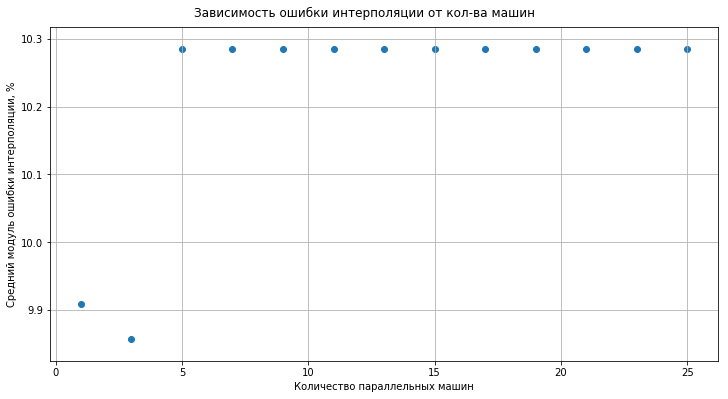

In [229]:
with open("greedyMultipleChebyshev.json", 'r') as f:
    globalResults = json.load(f)
globalResults = np.array(globalResults).T
x = []
y = []
for i, res in enumerate(globalResults):
    x.append(2*i + 1)
    y.append(np.mean(np.abs(res)))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от кол-ва машин")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Количество параллельных машин")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()
pBar.value += 1